In [1]:
import pm4py
from label_functions import *
import editdistance
from functions import *


# import data
def import_xes(file_path):
    event_log = pm4py.read_xes(file_path)
    start_activities = pm4py.get_start_activities(event_log)
    end_activities = pm4py.get_end_activities(event_log)
    print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))
    # convert all activity codes to strings
    event_log['Activity code'] = event_log['Activity code'].astype(str)
    return event_log

event_log = import_xes("data/Hospital_log.xes.gz")
print(type(event_log))
print(event_log)

parsing log, completed traces ::   0%|          | 0/1143 [00:00<?, ?it/s]

Start activities: {'1e consult poliklinisch': 71, 'inwend.geneesk.  korte kaart kosten-out': 8, 'verlosk.-gynaec. korte kaart kosten-out': 198, 'vervolgconsult poliklinisch': 234, 'verlosk.-gynaec.   jaarkaart kosten-out': 122, 'cytologisch onderzoek - ectocervix -': 28, 'echografie  - genitalia interna': 44, 'aanname laboratoriumonderzoek': 225, 'ligdagen - alle spec.beh.kinderg.-reval.': 39, 'telefonisch consult': 15, 'behandeltijd - eenheid t3 - megavolt': 1, 'ct abdomen': 2, 'behandeltijd - eenheid t2 - megavolt': 1, 'thorax': 12, 'e.c.g.      - elektrocardiografie': 63, 'cytologisch onderzoek - vagina -': 12, 'mammografie thoraxwand': 3, 'histologisch onderzoek - biopten nno': 19, 'dagverpleging - alle spec.beh.kind.-rev.': 5, 'inwend.geneesk.    jaarkaart kosten-out': 1, 'coupe ter inzage': 19, 'immunopathologisch onderzoek': 10, 'vagina      - scopie incl.evt.vulvabiops': 3, 'punctie tbv cytologisch onderzoek door p': 3, 'cytologisch onderzoek - buiktumorpunctie': 1, 'vrw.gesl.o

In [53]:
def label_function(log_df, required_activities):
    # Filter log to retain only traces with required activities
    filtered_df = pm4py.filtering.filter_event_attribute_values(
        log_df,
        attribute_key='concept:name',
        values=required_activities,
        level='case',
        retain=True,
        case_id_key='case:concept:name'
    )
    
    # Identify case IDs in the filtered DataFrame (these cases are normal)
    normal_cases = set(filtered_df['case:concept:name'].unique())
    
    # Create a dictionary mapping case IDs to 'normal' or 'deviant'
    case_labels = {
        case_id: 0 if case_id in normal_cases else 1
        for case_id in log_df['case:concept:name'].unique()
    }
    
    return case_labels

# Define required activities for this rule
required_activities_f1 = ['ca-19.9 tumormarker', 'ca-125 mbv meia']

# Generate the lf_map using the label function
lf_map = label_function(event_log, required_activities_f1)

In [54]:
from functions import *
from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from Levenshtein import distance as edit_distance
import numpy as np

# Step 1: Sort traces temporally by the first event's timestamp and split 80/20
event_log_sorted = event_log.sort_values(by='time:timestamp')
print(event_log_sorted['case:concept:name'])

# Calculate the split index for 80% of the cases, without dropping duplicates
split_index = int(0.8 * len(event_log_sorted))

# Split the sorted event log directly
train_log = event_log_sorted.iloc[:split_index]
test_log = event_log_sorted.iloc[split_index:]

# Verify split sizes
print("Train log size:", len(train_log))
print("Test log size:", len(test_log))


0         00000000
374       00000004
375       00000004
377       00000004
378       00000004
            ...   
150289    00001142
75066     00000591
75065     00000591
60896     00000518
150290    00001142
Name: case:concept:name, Length: 150291, dtype: object
Train log size: 120232
Test log size: 30059


In [55]:
# Define a function to safely transform data using LabelEncoder, handling unknown values
def safe_transform(encoder, value):
    # Ensure "Missing" is in encoder classes
    if "Missing" not in encoder.classes_:
        encoder.classes_ = np.append(encoder.classes_, "Missing")
        
    # If the value is in the encoder's known classes, transform it; otherwise, encode as "Missing"
    if value in encoder.classes_:
        return encoder.transform([value])[0]
    else:
        return encoder.transform(["Missing"])[0]


In [56]:
# Updated function with label_encoders as a parameter
def encode_data_attributes(event_log, prefixes_with_case_ids, attributes, label_encoders):
    encoded_data = []
    
    # Iterate over each (case_id, prefix)
    for case_id, prefix in prefixes_with_case_ids:
        # Get the last event in the current prefix
        last_event = prefix[-1]
        
        # Filter the event_log for the specific case and last event
        event_rows = event_log[
            (event_log['case:concept:name'] == case_id) & 
            (event_log['Activity code'] == last_event)
        ]
        
        if event_rows.empty:
            print(f"No matching event found for case {case_id} and activity {last_event}")
            # Encode missing data explicitly as "Missing"
            data_vector = [safe_transform(label_encoders[attr], "Missing") for attr in attributes]
        else:
            # Take the first occurrence and encode each attribute
            event_row = event_rows.iloc[0]
            data_vector = [
                safe_transform(label_encoders[attr], str(event_row[attr]))
                for attr in attributes
            ]
        
        # Add the encoded vector to the results
        encoded_data.append(data_vector)
    
    return encoded_data

In [57]:

# Step 2: Extract prefixes from training set with specified step sizes
def extract_prefixes(trace, max_len=21, step=5):
    return [trace[:i] for i in range(1, max_len + 1, step) if i <= len(trace)]

# Group and extract prefixes from training traces
train_traces = train_log.groupby('case:concept:name')['Activity code'].apply(list)
all_prefixes = train_traces.apply(lambda x: extract_prefixes(x)).explode()

In [58]:
# Initialize label encoders
from sklearn.preprocessing import LabelEncoder

X_cols = ['case:Diagnosis code', 'case:Treatment code']
label_encoders = {col: LabelEncoder() for col in X_cols}
for col in X_cols:
    label_encoders[col].fit(train_log[col].astype(str))  # Fit encoders with the training log

# Encode each prefix individually
encoded_prefixes = []
for case_id, prefix in all_prefixes.items():
    # Encode attributes for each prefix and store
    encoded_prefix = encode_data_attributes(train_log, [(case_id, prefix)], X_cols, label_encoders)
    encoded_prefixes.append(encoded_prefix[0])  # Store each encoded prefix

In [60]:
# Convert each encoded prefix to a sequence for DBSCAN
sequence_encoded_prefixes = [' '.join(map(str, encoded_prefix)) for encoded_prefix in encoded_prefixes]

In [61]:

# Step 3: Compute edit distance matrix for the training set only
n_train = len(sequence_encoded_prefixes)
train_distance_matrix = np.zeros((n_train, n_train))
for i in range(n_train):
    for j in range(i + 1, n_train):
        dist = edit_distance(sequence_encoded_prefixes[i], sequence_encoded_prefixes[j])
        train_distance_matrix[i, j] = dist
        train_distance_matrix[j, i] = dist  # Symmetric matrix

# Step 4: Apply DBSCAN on the training set using the specified parameters
dbscan = DBSCAN(eps=0.125, min_samples=4, metric='precomputed')
#dbscan = DBSCAN(eps=0.15, min_samples=6, metric='precomputed')
#dbscan = DBSCAN(eps=0.2, min_samples=6, metric='precomputed')
train_cluster_labels = dbscan.fit_predict(train_distance_matrix)

In [62]:
# Columns used for classifier training
X_cols = ['case:Diagnosis code', 'case:Treatment code']

# Define a threshold for the minimum number of samples required -- OPTIONAL -- TO IMPROVE ROBUSTNESS
min_samples_threshold = 10

# Step 5: Train a classifier for each cluster in the training set
clusters = {}
for cluster_label in np.unique(train_cluster_labels):
    if cluster_label == -1:
        continue  # Skip noise points
    
    # Get indices of prefixes in the current cluster
    cluster_indices = [i for i, label in enumerate(train_cluster_labels) if label == cluster_label]
    
    # Prepare a list of (case_id, prefix) tuples
    prefixes_with_case_ids = [
        (all_prefixes.index[i], all_prefixes.iloc[i]) 
        for i in cluster_indices
    ]
    
    # Encode data attributes, passing label_encoders as an argument
    #X_cluster = encode_data_attributes(train_log, prefixes_with_case_ids, X_cols, label_encoders)
    
    X_cluster = [encoded_prefixes[i] for i in cluster_indices]
    # Get labels for each prefix using lf_map
    y_cluster = [lf_map[case_id] for case_id, _ in prefixes_with_case_ids]
    
    # Print cluster size for inspection
    print(f"Cluster {cluster_label}: Size of X_cluster = {len(X_cluster)}, Size of y_cluster = {len(y_cluster)}")

    # Check if the cluster size is too small
    if len(X_cluster) <= 5:
        print(f"Warning: Cluster {cluster_label} has very few samples ({len(X_cluster)}). Consider adjusting DBSCAN parameters.")
        continue  # Skip clusters that are too small

    # Train decision tree classifier for the current cluster
    clf = DecisionTreeClassifier()
    clf.fit(X_cluster, y_cluster)
    clusters[cluster_label] = clf  # Store classifier by cluster label


Cluster 0: Size of X_cluster = 76, Size of y_cluster = 76
Cluster 1: Size of X_cluster = 30, Size of y_cluster = 30
Cluster 2: Size of X_cluster = 5, Size of y_cluster = 5
Cluster 3: Size of X_cluster = 30, Size of y_cluster = 30
Cluster 4: Size of X_cluster = 1552, Size of y_cluster = 1552
Cluster 5: Size of X_cluster = 10, Size of y_cluster = 10
Cluster 6: Size of X_cluster = 21, Size of y_cluster = 21
Cluster 7: Size of X_cluster = 106, Size of y_cluster = 106
Cluster 8: Size of X_cluster = 170, Size of y_cluster = 170
Cluster 9: Size of X_cluster = 35, Size of y_cluster = 35
Cluster 10: Size of X_cluster = 55, Size of y_cluster = 55
Cluster 11: Size of X_cluster = 211, Size of y_cluster = 211
Cluster 12: Size of X_cluster = 212, Size of y_cluster = 212
Cluster 13: Size of X_cluster = 139, Size of y_cluster = 139
Cluster 14: Size of X_cluster = 15, Size of y_cluster = 15
Cluster 15: Size of X_cluster = 89, Size of y_cluster = 89
Cluster 16: Size of X_cluster = 119, Size of y_cluster

In [85]:
# Step 6: Define functions for finding the closest cluster and for reliable prediction

def find_closest_cluster(running_trace, train_prefixes, train_cluster_labels):
    # Convert running trace to sequence encoding
    running_sequence = ' '.join(map(str, running_trace))
    # Calculate edit distances between the running trace and each training prefix
    distances = [edit_distance(running_sequence, train_seq) for train_seq in train_prefixes]
    # Get the closest training prefix and its corresponding cluster label
    closest_idx = np.argmin(distances)
    closest_cluster = train_cluster_labels[closest_idx]
    return closest_cluster, closest_idx

def predict_with_reliability(clf, X_test, thresholds=[0.3, 0.4, 0.5, 0.6, 0.7], min_class_support=1):
    # Get the prediction probabilities for the test input
    probs = clf.predict_proba([X_test])[0]
    predicted_class = np.argmax(probs)
    class_support = np.sum(clf.classes_ == predicted_class)
    class_prob = probs[predicted_class]

    # Check reliability of the prediction based solely on probability thresholds
    reliability_check = class_support >= min_class_support and any(class_prob >= t for t in thresholds)

    if reliability_check:
        return predicted_class, class_prob

    return None, None

In [86]:
# Inspect keys in lf_map
print("Keys in lf_map:", list(lf_map.items()))  # Display the first few keys for inspection


Keys in lf_map: [('00000000', 1), ('00000001', 1), ('00000002', 0), ('00000003', 1), ('00000004', 0), ('00000005', 1), ('00000006', 0), ('00000007', 0), ('00000008', 1), ('00000009', 0), ('00000010', 0), ('00000011', 0), ('00000012', 0), ('00000013', 1), ('00000014', 1), ('00000015', 1), ('00000016', 1), ('00000017', 0), ('00000018', 0), ('00000019', 1), ('00000020', 0), ('00000021', 1), ('00000022', 1), ('00000023', 0), ('00000024', 1), ('00000025', 1), ('00000026', 1), ('00000027', 0), ('00000028', 1), ('00000029', 1), ('00000030', 0), ('00000031', 1), ('00000032', 0), ('00000033', 0), ('00000034', 1), ('00000035', 1), ('00000036', 0), ('00000037', 1), ('00000038', 0), ('00000039', 0), ('00000040', 1), ('00000041', 1), ('00000042', 1), ('00000043', 1), ('00000044', 0), ('00000045', 0), ('00000046', 1), ('00000047', 0), ('00000048', 0), ('00000049', 1), ('00000050', 1), ('00000051', 1), ('00000052', 0), ('00000053', 1), ('00000054', 0), ('00000055', 1), ('00000056', 1), ('00000057', 1

In [78]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Store true and predicted labels
true_labels = []
predicted_labels = []
# Define the sequence of steps
step_sequence = [21, 16, 11, 6, 1]
max_prefix_length = 21  # Set the maximum prefix length

# Iterate over each test trace with case IDs
for case_id, test_trace in test_log.groupby('case:concept:name')['Activity code'].apply(list).items():
    reliable_prediction = False
    y_test = lf_map.get(case_id)  # Get true label for the test trace
    y_pred = None  # Initialize predicted label for the trace

    if y_test is None:
        print(f"Warning: No label found for {case_id} in lf_map")
        continue

    # Iteratively extract prefixes from the test trace
    i = 0
    while i < len(test_trace) and len(test_trace[:i + 1]) <= max_prefix_length:
        current_prefix = test_trace[:i + 1]

        # Encode the current prefix using encode_data_attributes, with 'Missing' handling
        prefixes_with_case_ids = [(case_id, current_prefix)]
        X_test = encode_data_attributes(test_log, prefixes_with_case_ids, X_cols, label_encoders)[0]
        encoded_prefix = ' '.join(map(str, X_test))

        # Find the closest cluster by computing edit distances with training encoded prefixes
        distances = [edit_distance(encoded_prefix, train_prefix) for train_prefix in sequence_encoded_prefixes]
        closest_idx = np.argmin(distances)
        closest_cluster = train_cluster_labels[closest_idx]

        if closest_cluster == -1:
            # Move to the next prefix step if the closest cluster is noise
            i += step_sequence[0] if len(step_sequence) > 0 else 5
            continue

        # Retrieve the classifier for the closest cluster
        clf = clusters.get(closest_cluster)
        if clf:
            # Make a prediction with reliability checking
            y_pred, confidence = predict_with_reliability(clf, X_test)

            if y_pred is not None:
                print(f"Reliable prediction achieved: {y_pred} with confidence {confidence}")
                reliable_prediction = True
                break  # Stop if a reliable prediction is made

        # Move to the next step in the sequence
        i += step_sequence.pop(0) if step_sequence else 5

    # Append the final true and predicted labels for evaluation
    true_labels.append(y_test)
    predicted_labels.append(y_pred if reliable_prediction else None)

    if not reliable_prediction:
        print(f"Prediction failure: No reliable prediction achieved for case {case_id}.")

Reliable prediction achieved: 0 with confidence 0.8333333333333334
Prediction failure: No reliable prediction achieved for case 00000005.
Reliable prediction achieved: 1 with confidence 0.538659793814433
Reliable prediction achieved: 1 with confidence 0.538659793814433
Reliable prediction achieved: 1 with confidence 0.538659793814433
Reliable prediction achieved: 1 with confidence 0.538659793814433
Reliable prediction achieved: 1 with confidence 0.538659793814433
Reliable prediction achieved: 1 with confidence 0.538659793814433
Reliable prediction achieved: 1 with confidence 0.538659793814433
Reliable prediction achieved: 1 with confidence 0.538659793814433
Reliable prediction achieved: 0 with confidence 1.0
Reliable prediction achieved: 1 with confidence 0.538659793814433
Reliable prediction achieved: 1 with confidence 0.538659793814433
Reliable prediction achieved: 1 with confidence 0.538659793814433
Reliable prediction achieved: 1 with confidence 0.538659793814433
Reliable predictio

In [87]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Store true and predicted labels
true_labels = []
predicted_labels = []
# Define the sequence of steps
step_sequence = [21, 16, 11, 6, 1]
max_prefix_length = 21  # Set the maximum prefix length

# Iterate over each test trace with case IDs
for case_id, test_trace in test_log.groupby('case:concept:name')['Activity code'].apply(list).items():
    reliable_prediction = False
    y_test = lf_map.get(case_id)  # Get true label for the test trace
    y_pred = None  # Initialize predicted label for the trace

    if y_test is None:
        print(f"Warning: No label found for {case_id} in lf_map")
        continue

    i = max_prefix_length
    while i > 0 and len(test_trace[:i]) <= max_prefix_length:
        current_prefix = test_trace[:i]


        # Encode the current prefix using encode_data_attributes, with 'Missing' handling
        prefixes_with_case_ids = [(case_id, current_prefix)]
        X_test = encode_data_attributes(test_log, prefixes_with_case_ids, X_cols, label_encoders)[0]
        encoded_prefix = ' '.join(map(str, X_test))

        # Find the closest cluster by computing edit distances with training encoded prefixes
        distances = [edit_distance(encoded_prefix, train_prefix) for train_prefix in sequence_encoded_prefixes]
        closest_idx = np.argmin(distances)
        closest_cluster = train_cluster_labels[closest_idx]

        if closest_cluster == -1:
            # Move to the next prefix step if the closest cluster is noise
            i += step_sequence[0] if len(step_sequence) > 0 else 5
            continue

        # Retrieve the classifier for the closest cluster
        clf = clusters.get(closest_cluster)
        if clf:
            # Make a prediction with reliability checking
            y_pred, confidence = predict_with_reliability(clf, X_test)

            if y_pred is not None:
                print(f"Reliable prediction achieved: {y_pred} with confidence {confidence}")
                reliable_prediction = True
                break  # Stop if a reliable prediction is made

        # Move to the next step in the sequence
        i -= step_sequence.pop(0) if step_sequence else 5

    # Append the final true and predicted labels for evaluation
    true_labels.append(y_test)
    predicted_labels.append(y_pred if reliable_prediction else None)

    if not reliable_prediction:
        print(f"Prediction failure: No reliable prediction achieved for case {case_id}.")

Reliable prediction achieved: 0 with confidence 0.8333333333333334
Prediction failure: No reliable prediction achieved for case 00000005.
Reliable prediction achieved: 1 with confidence 0.538659793814433
Reliable prediction achieved: 1 with confidence 0.538659793814433
Reliable prediction achieved: 1 with confidence 0.538659793814433
Reliable prediction achieved: 1 with confidence 0.538659793814433
Reliable prediction achieved: 1 with confidence 0.538659793814433
Reliable prediction achieved: 1 with confidence 0.538659793814433
Reliable prediction achieved: 1 with confidence 0.538659793814433
Reliable prediction achieved: 1 with confidence 0.538659793814433
Reliable prediction achieved: 0 with confidence 1.0
Reliable prediction achieved: 1 with confidence 0.538659793814433
Reliable prediction achieved: 1 with confidence 0.538659793814433
Reliable prediction achieved: 1 with confidence 0.538659793814433
Reliable prediction achieved: 1 with confidence 0.538659793814433
Reliable predictio

F1 Score: 0.746


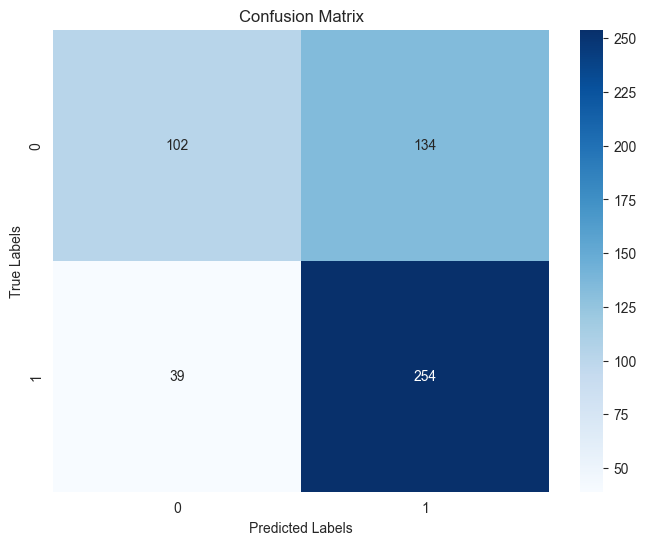

In [88]:
from collections import Counter

# Filter out cases where no reliable prediction was made (i.e., where y_pred is None)
filtered_true_labels = [y for y, pred in zip(true_labels, predicted_labels) if pred is not None]
filtered_predicted_labels = [pred for pred in predicted_labels if pred is not None]

# Check if there are any valid predictions left for evaluation
if filtered_predicted_labels:
    # Evaluate the predictions
    f1 = f1_score(filtered_true_labels, filtered_predicted_labels, average='binary')
    print(f'F1 Score: {f1:.3f}')

    # Plot the confusion matrix
    cm = confusion_matrix(filtered_true_labels, filtered_predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[0, 1], yticklabels=[0, 1])  # Updated labels to match integer encoding
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
else:
    print("No valid predictions to evaluate. Check clustering, classifier training, or reliability criteria.")
